**IMPORT LIBRARY**

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.datasets import make_circles, make_blobs
from sklearn.linear_model import Perceptron
import cvxopt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

**GENERATE AND VISUALIZE DATA**

<Axes: >

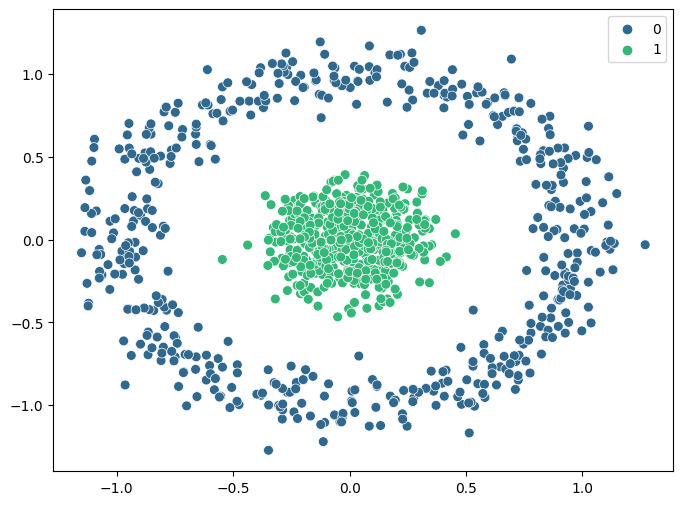

In [16]:
X, y = make_circles(n_samples = 1000, shuffle=True, noise=0.1, random_state = 19, factor= 0.2)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="viridis", s=50, edgecolor='w', linewidth=0.5)

In [17]:
y = np.where(y <= 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [18]:
def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f

def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

**INITIALIZE MODEL KERNEL_SVM**

In [19]:
cvxopt.solvers.options['show_progress'] = True

class Kernel_SVM():
    def __init__(self, C=1.0, kernel=rbf_kernel, power=3, gamma=None, coef=1):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.a = None
        self.X = None
        self.sv_y = None
        self.intercept = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Initialize kernel matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * K, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')
        G = cvxopt.matrix(np.vstack((np.eye(n_samples)*-1,np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solve the quadratic optimization problem using cvxopt
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-7
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Calculate intercept with first support vector
        self.intercept = self.sv_y[0]
        for i in range(len(self.a)):
            self.intercept = self.intercept.astype('float64') - self.a[i] * self.sv_y[i] * self.kernel(self.sv[i], self.sv[0]).astype('float64')


    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.a)):
                prediction += self.a[i] * self.sv_y[i] * self.kernel(self.sv[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

**C = 0.1**

**DEPLOY INITIALIZED MODEL**

In [20]:
C = 0.1

rbf0 = Kernel_SVM(C=C, kernel=rbf_kernel, gamma=0.1)
rbf0.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.3194e+02 -1.8880e+02  4e+03  2e+01  4e-15
 1: -7.7176e+01 -1.6105e+02  3e+02  1e+00  3e-15
 2: -6.0304e+01 -9.5929e+01  4e+01  1e-15  2e-15
 3: -6.6009e+01 -6.7667e+01  2e+00  2e-15  1e-15
 4: -6.6616e+01 -6.7025e+01  4e-01  2e-16  1e-15
 5: -6.6691e+01 -6.6775e+01  8e-02  2e-15  1e-15
 6: -6.6712e+01 -6.6782e+01  7e-02  2e-15  1e-15
 7: -6.6728e+01 -6.6761e+01  3e-02  2e-15  1e-15
 8: -6.6740e+01 -6.6745e+01  5e-03  1e-15  1e-15
 9: -6.6741e+01 -6.6743e+01  2e-03  1e-15  1e-15
10: -6.6742e+01 -6.6743e+01  5e-04  1e-15  1e-15
11: -6.6742e+01 -6.6742e+01  2e-05  2e-15  2e-15
Optimal solution found.


**CLASSIFICATION REPORT**

Accuracy:  0.4950
Lớp 0: Precision =  1.0000, Recall =  0.0288, F1 Score =  0.0561
Lớp 1: Precision =  0.4873, Recall =  1.0000, F1 Score =  0.6553

               precision    recall  f1-score   support

          -1       1.00      0.03      0.06       104
           1       0.49      1.00      0.66        96

    accuracy                           0.49       200
   macro avg       0.74      0.51      0.36       200
weighted avg       0.75      0.49      0.34       200



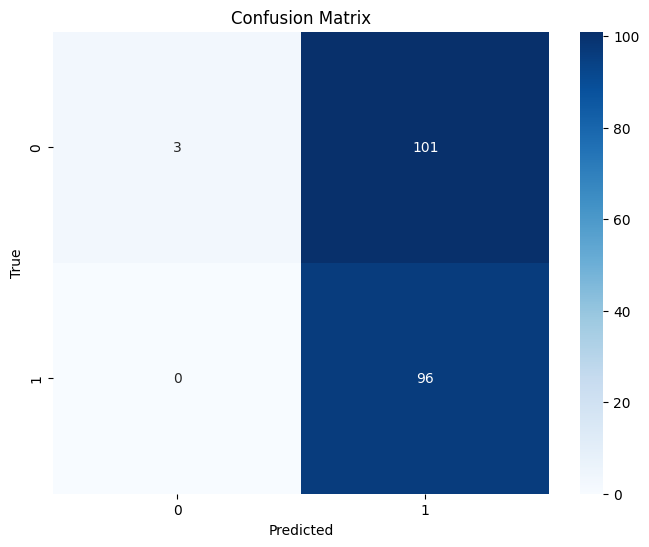

In [21]:
predictions = rbf0.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**C = 1**

**DEPLOY INITIALIZED MODEL**

In [22]:
C = 1

rbf1 = Kernel_SVM(C=C, kernel=rbf_kernel, gamma=0.1)
rbf1.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.6266e+02 -1.5633e+03  5e+03  2e+00  7e-15
 1: -1.4230e+02 -8.9674e+02  8e+02  4e-15  6e-15
 2: -1.6577e+02 -2.6265e+02  1e+02  2e-16  5e-15
 3: -1.9278e+02 -2.1383e+02  2e+01  5e-15  6e-15
 4: -1.9990e+02 -2.0659e+02  7e+00  9e-15  7e-15
 5: -2.0207e+02 -2.0442e+02  2e+00  9e-15  7e-15
 6: -2.0291e+02 -2.0357e+02  7e-01  5e-15  7e-15
 7: -2.0320e+02 -2.0328e+02  8e-02  4e-15  8e-15
 8: -2.0324e+02 -2.0325e+02  1e-02  7e-15  8e-15
 9: -2.0324e+02 -2.0324e+02  2e-03  9e-15  8e-15
10: -2.0324e+02 -2.0324e+02  1e-04  1e-14  8e-15
Optimal solution found.


**CLASSIFICATION REPORT**

Accuracy:  0.9950
Lớp 0: Precision =  1.0000, Recall =  0.9904, F1 Score =  0.9952
Lớp 1: Precision =  0.9897, Recall =  1.0000, F1 Score =  0.9948

               precision    recall  f1-score   support

          -1       1.00      0.99      1.00       104
           1       0.99      1.00      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



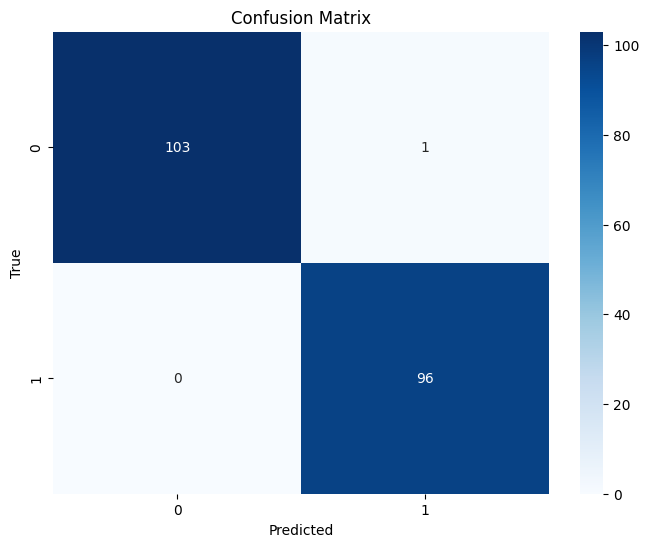

In [23]:
predictions = rbf1.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**C = 10**

**DEPLOY INITIALIZED MODEL**

In [24]:
C = 10

rbf2 = Kernel_SVM(C=C, kernel=rbf_kernel, gamma=0.1)
rbf2.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  3.3533e+03 -4.5733e+04  8e+04  4e-01  4e-14
 1:  1.9975e+03 -5.3981e+03  7e+03  1e-14  3e-14
 2:  1.6439e+02 -1.3962e+03  2e+03  6e-15  2e-14
 3:  4.1904e+01 -1.2291e+03  1e+03  2e-15  2e-14
 4: -1.6605e+02 -7.5052e+02  6e+02  1e-14  2e-14
 5: -1.8100e+02 -7.3116e+02  6e+02  6e-15  2e-14
 6: -2.1274e+02 -7.2662e+02  5e+02  2e-15  2e-14
 7: -2.6995e+02 -6.0991e+02  3e+02  5e-15  2e-14
 8: -3.0748e+02 -5.5146e+02  2e+02  5e-15  2e-14
 9: -3.3868e+02 -5.0551e+02  2e+02  1e-14  3e-14
10: -3.5702e+02 -4.7847e+02  1e+02  4e-14  3e-14
11: -3.7103e+02 -4.5703e+02  9e+01  1e-14  3e-14
12: -3.8384e+02 -4.3794e+02  5e+01  3e-15  3e-14
13: -3.9009e+02 -4.2887e+02  4e+01  6e-16  3e-14
14: -3.9597e+02 -4.2046e+02  2e+01  9e-15  3e-14
15: -4.0087e+02 -4.1346e+02  1e+01  1e-14  3e-14
16: -4.0435e+02 -4.0867e+02  4e+00  2e-14  3e-14
17: -4.0616e+02 -4.0643e+02  3e-01  4e-15  4e-14
18: -4.0628e+02 -4.0629e+02  1e-02  1e-14  4e-14
19: -4.0628e+02 -4.06

**CLASSIFICATION REPORT**

Accuracy:  1.0000
Lớp 0: Precision =  1.0000, Recall =  1.0000, F1 Score =  1.0000
Lớp 1: Precision =  1.0000, Recall =  1.0000, F1 Score =  1.0000

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



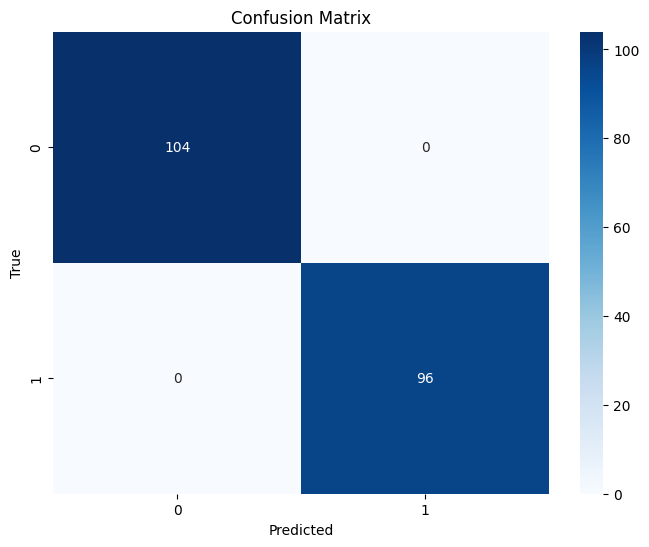

In [25]:
predictions = rbf2.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**C = 100**

**DEPLOY INITIALIZED MODEL**

In [26]:
C = 100

rbf3 = Kernel_SVM(C=C, kernel=rbf_kernel, gamma=0.1)
rbf3.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  4.2083e+05 -3.5055e+06  6e+06  2e-01  4e-13
 1:  2.0513e+05 -3.0759e+05  5e+05  9e-03  3e-13
 2:  3.4523e+04 -5.1079e+04  9e+04  3e-04  2e-13
 3:  4.4899e+03 -8.7200e+03  1e+04  6e-14  9e-14
 4:  9.1010e+02 -2.9757e+03  4e+03  3e-14  5e-14
 5:  2.8464e+02 -2.1316e+03  2e+03  1e-14  5e-14
 6:  1.4013e+02 -2.0311e+03  2e+03  9e-14  7e-14
 7: -8.8184e+01 -1.8032e+03  2e+03  1e-14  7e-14
 8: -1.1733e+02 -1.7907e+03  2e+03  9e-14  8e-14
 9: -2.8226e+02 -1.5233e+03  1e+03  4e-14  8e-14
10: -3.2031e+02 -1.4867e+03  1e+03  4e-14  9e-14
11: -4.1106e+02 -1.3536e+03  9e+02  4e-14  1e-13
12: -4.4263e+02 -1.2086e+03  8e+02  7e-14  1e-13
13: -4.9476e+02 -1.1594e+03  7e+02  1e-15  1e-13
14: -5.5002e+02 -1.0482e+03  5e+02  4e-14  2e-13
15: -6.2801e+02 -9.2729e+02  3e+02  2e-14  2e-13
16: -6.6161e+02 -8.6713e+02  2e+02  1e-13  2e-13
17: -6.9404e+02 -8.0760e+02  1e+02  1e-13  2e-13
18: -7.1771e+02 -7.7701e+02  6e+01  9e-14  2e-13
19: -7.3129e+02 -7.61

**CLASSIFICATION REPORT**

Accuracy:  1.0000
Lớp 0: Precision =  1.0000, Recall =  1.0000, F1 Score =  1.0000
Lớp 1: Precision =  1.0000, Recall =  1.0000, F1 Score =  1.0000

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



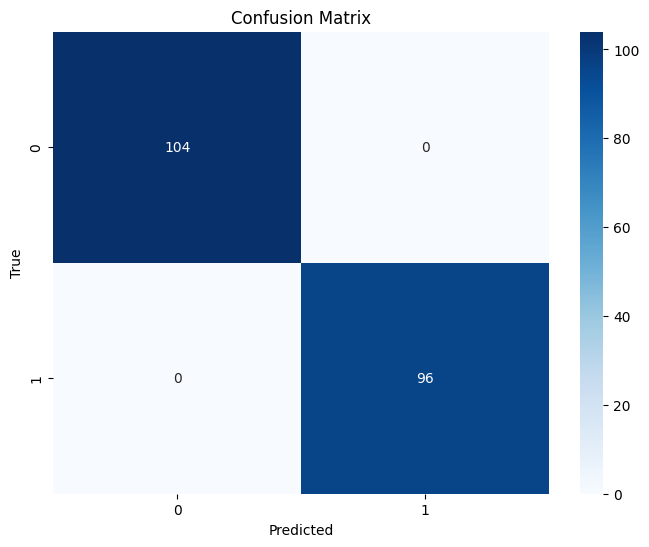

In [27]:
predictions = rbf3.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**VISUALIZE DATA AND DECISION BOUNDARY (COMPARE BETWEEN SELF-DEFINE FUNCTION AND MODEL SVC)**

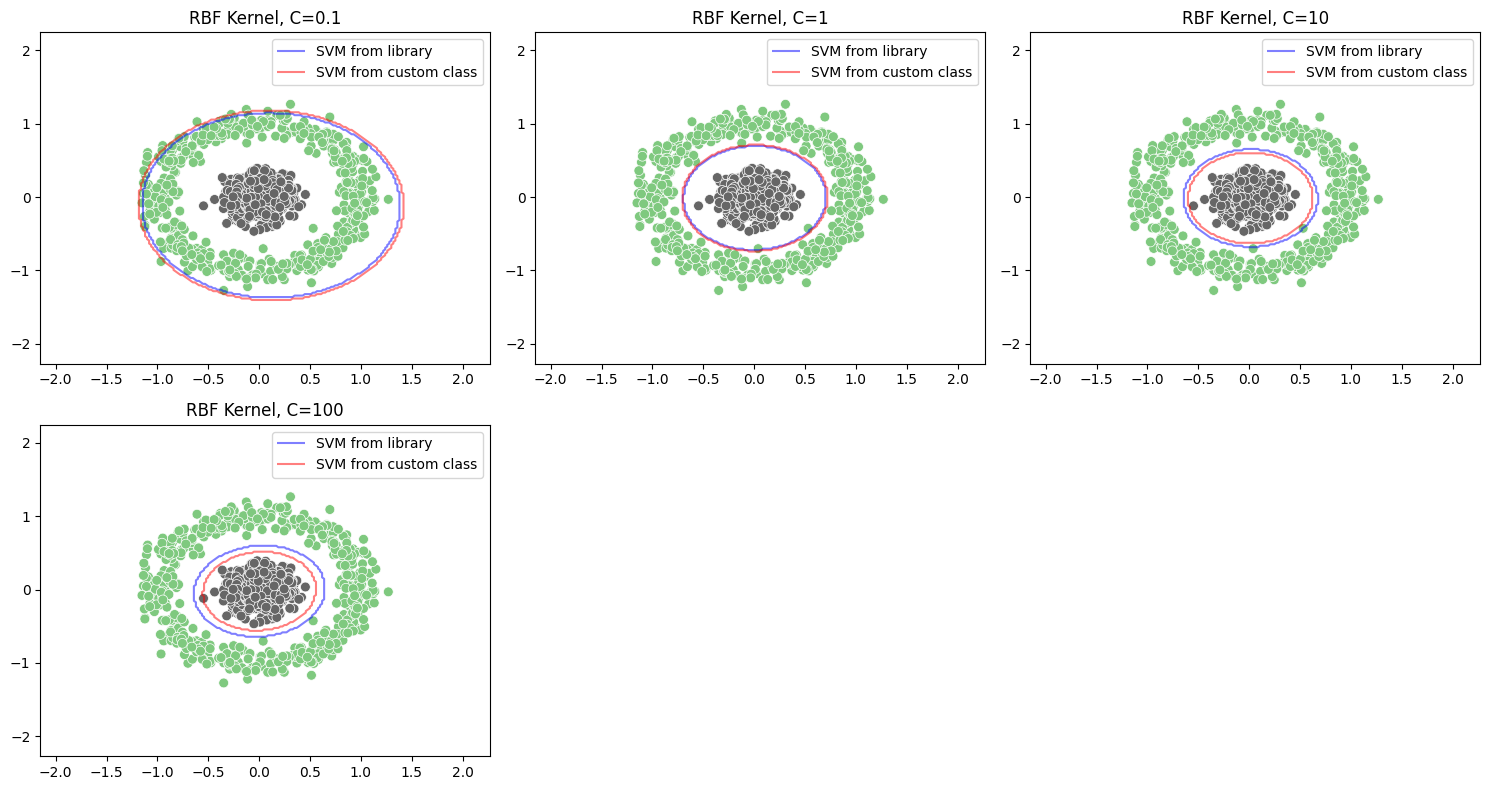

In [29]:
from sklearn import svm

C_arrays = [0.1, 1, 10, 100]
models = [svm.SVC(C=c, kernel='rbf', gamma=0.1) for c in C_arrays]
svm_rbf = [rbf0, rbf1, rbf2, rbf3]

def plot_decision_boundary(lib, svm, title):
  # Plot the decision boundary.
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  h = .02  # step size in the mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

  # Predictions for library SVM
  Z_lib = lib.predict(np.c_[xx.ravel(), yy.ravel()])

  # Predictions for custom SVM
  Z_cust = svm.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z_lib = Z_lib.reshape(xx.shape)
  Z_cust = Z_cust.reshape(xx.shape)

  # Plot decision boundary for library SVM
  contour_lib = plt.contour(xx, yy, Z_lib, colors='b', levels=[0], alpha=0.5, linestyles=['-'])

  # Plot decision boundary for custom SVM
  contour_cust = plt.contour(xx, yy, Z_cust, colors='r', levels=[0], alpha=0.5, linestyles=['-'])

  h1,_ = contour_lib.legend_elements()
  h2,_ = contour_cust.legend_elements()
  plt.legend([h1[0], h2[0]], ['SVM from library', 'SVM from custom class'])

  # Plot also the training points
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', edgecolor='w', s=50, linewidth=0.5)
  plt.title(title)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(15, 8))
for i, model in enumerate(models):
    plt.subplot(2, 3, i + 1)
    plt.xlim(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1)
    plt.ylim(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1)

    model.fit(X_train, y_train)
    plot_decision_boundary(model, svm_rbf[i], f'RBF Kernel, C={C_arrays[i]}')

plt.tight_layout()
plt.show()

**EXAMPLE OF USING MODEL FOR CIFAR10**

In [ ]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170498071/170498071 [==============================] - 5s 0us/step


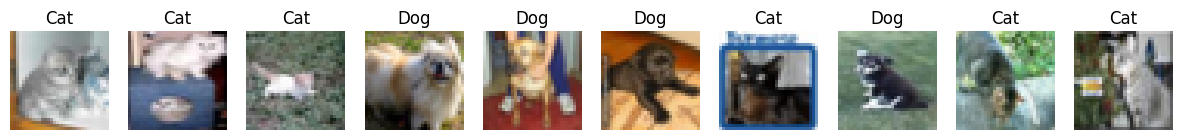

In [ ]:
# Take data samples labeled "Dog" or "Cat"
dog_cat_indices = [class_names.index('Dog'), class_names.index('Cat')]
mask = np.any(y_train == dog_cat_indices, axis=1)
X_train_dog_cat = X_train[mask]
y_train_dog_cat = y_train[mask]

plt.figure(figsize=(15, 3))
for i in range(10):
    i_ = i + 6
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train_dog_cat[i_])
    plt.title(class_names[int(y_train_dog_cat[i_])])
    plt.axis('off')

plt.show()

In [ ]:
def cat_or_dog(label):
  return label==3 or label==5

train_index=[]
test_index=[]
for i in range(len(y_train)):
  if cat_or_dog(y_train[i])==True:
    train_index.append(i)
for i in range(len(y_test)):
  if cat_or_dog(y_test[i])==True:
    test_index.append(i)

X_train = X_train[train_index]
y_train = y_train[train_index]
X_test = X_test[test_index]
y_test = y_test[test_index]

y_train = np.where(y_train == 3, -1, 1)
y_test = np.where(y_test == 3, -1, 1)

X_train, y_train = shuffle(X_train, y_train)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

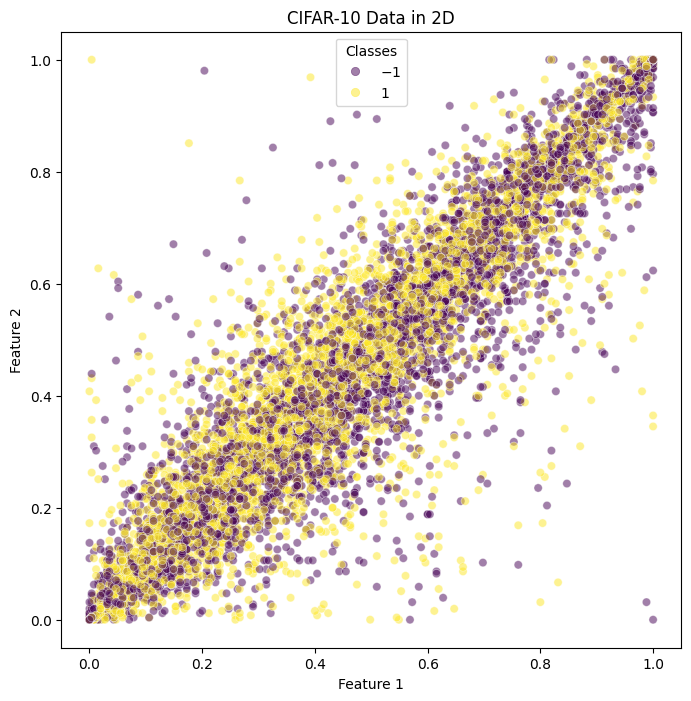

In [ ]:
# Hiển thị scatter plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap='viridis', alpha=0.5, edgecolor='w', linewidth=0.5)
plt.title('CIFAR-10 Data in 2D')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

In [ ]:
# Create an SVC model with the kernel parameter set to 'rbf'
svm_rbf = Kernel_SVM(C = 1, kernel = rbf_kernel, gamma=0.1)
svm_rbf.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -4.4357e+03 -1.6112e+04  1e+04  6e-14  3e-15
 1: -4.6743e+03 -5.4460e+03  8e+02  1e-13  1e-15
 2: -4.9390e+03 -5.0437e+03  1e+02  3e-14  6e-16
 3: -4.9794e+03 -4.9940e+03  1e+01  6e-14  2e-16
 4: -4.9852e+03 -4.9872e+03  2e+00  6e-14  1e-16
 5: -4.9860e+03 -4.9863e+03  3e-01  6e-14  1e-16
 6: -4.9861e+03 -4.9862e+03  4e-02  2e-13  1e-16
 7: -4.9861e+03 -4.9861e+03  5e-03  1e-13  1e-16
Optimal solution found.


Accuracy:  0.5465
Lớp 0: Precision =  0.5274, Recall =  0.8960, F1 Score =  0.6639
Lớp 1: Precision =  0.6545, Recall =  0.1970, F1 Score =  0.3028

               precision    recall  f1-score   support

          -1       0.53      0.90      0.66      1000
           1       0.65      0.20      0.30      1000

    accuracy                           0.55      2000
   macro avg       0.59      0.55      0.48      2000
weighted avg       0.59      0.55      0.48      2000



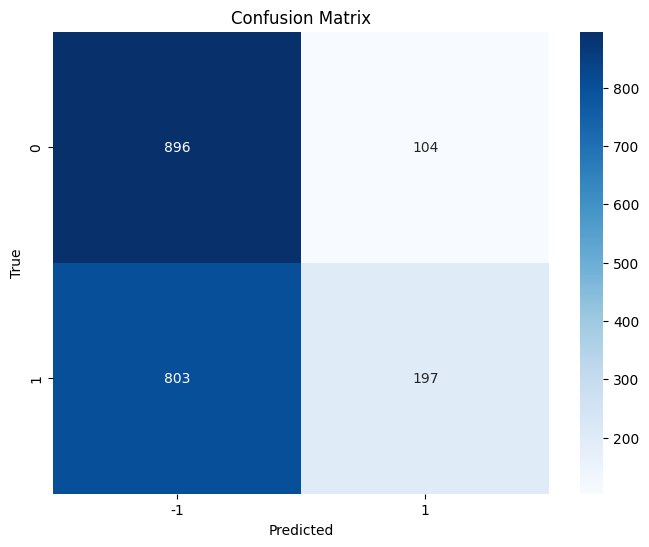

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
predictions = svm_rbf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn import svm
svc = svm.SVC(C = 1, kernel='rbf', gamma=0.1)
svc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, gamma=0.1)

Accuracy:  0.5460
Lớp 0: Precision =  0.6917, Recall =  0.1660, F1 Score =  0.2677
Lớp 1: Precision =  0.5261, Recall =  0.9260, F1 Score =  0.6710

               precision    recall  f1-score   support

          -1       0.69      0.17      0.27      1000
           1       0.53      0.93      0.67      1000

    accuracy                           0.55      2000
   macro avg       0.61      0.55      0.47      2000
weighted avg       0.61      0.55      0.47      2000



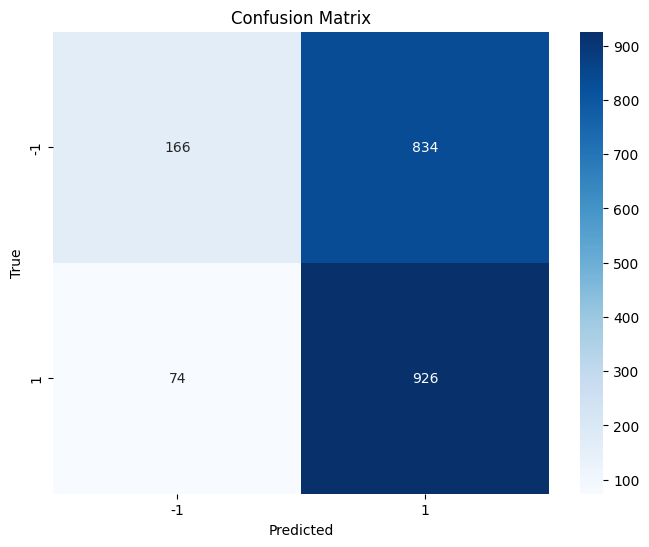

In [ ]:
predictions = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions): .4f}")

precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

for i in range(len(precision)):
    print(f"Lớp {i}: Precision = {precision[i]: .4f}, Recall = {recall[i]: .4f}, F1 Score = {f1[i]: .4f}")

report = classification_report(y_test, predictions)
print("\n", report)


cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()